# create ntbk to perform rk integration for multiple variables

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# define our coupled derivatives to integrate

In [7]:
def dydx(x,y):
    #set the derivatives
    #our equation is d^2x/dx^2 = -y
    #so we can write
    #dydx = z
    #dzdx = -y
    
    #we will set y = y[0]
    #we will set z = y[1]
    
    #declare an array
    y_derivs = np.zeros(2)
    
    #set dydx = z
    y_derivs[0] = y[1]
    #set dzdx = -y
    y_derivs[1] = -1*y[0]
    
    #return arrays of dydx
    return y_derivs

# Define the 4th order RK method

In [8]:
def rk4_mv_core(dydx,xi,yi,nv,h):
    
    #declare k? arrays (? any digit 0-9)
    k1 = np.zeros(nv)
    k2 = np.zeros(nv)
    k3 = np.zeros(nv)
    k4 = np.zeros(nv)
    
    #define x at 1/2 step
    x_ipoh = xi + 0.5*h
    
    #define x at 1 step
    x_ipo = xi + h
    
    #declare a temp y array
    y_temp = np.zeros(nv)
    
    
    #get k1 values
    y_derivs = dydx(xi,yi)
    k1[:] = h*y_derivs[:]
    
    #get the k2 values
    y_temp[:] = yi[:] + 0.5*k1[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k2[:] = h*y_derivs[:]
    
    #get k3 values
    y_temp[:] = yi[:] + 0.5*k2[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k3[:] = h*y_derivs[:]
    
    #get k4 values
    y_temp[:] = yi[:] + 0.5*k3[:]
    y_derivs = dydx(x_ipoh,y_temp)
    k4[:] = h*y_derivs[:]
    
    #advance y by a step h
    yipo = yi + (k1 + 2*k2 + 2*k3 + k4)/6.
    
    #this is an array (yipo = y i plus one)
    return yipo

#  define an adaptive step size friver for rk4

In [33]:
def rk4_mv_ad(dydx,x_i,y_i,nv,h,tol):
    
    #define safety scale
    SAFETY = 0.9
    H_NEW_FAC = 2.0
    
    #set a maximum number of iterarions
    imax = 10000
    
    #set an iteration variable
    i = 0
    
    #create an error
    Delta = np.full(nv,2*tol)
    
    #remember the step
    h_step = h
    
    #adjust the step
    while(Delta.max()/tol > 1.0):
        
        #estimate our error by taking one step of size h vs. 2 steps of size h/2
        y_2 = rk4_mv_core(dydx,x_i,y_i,nv,h_step)
        y_1 = rk4_mv_core(dydx,x_i,y_i,nv,0.5*h_step)
        y_11 = rk4_mv_core(dydx,x_i + 0.5*h_step,y_1,nv,0.5*h_step)
        
        #compute an error
        Delta = np.fabs(y_2 - y_11)
        
        #if the error is too large, decrease the step
        if (Delta.max()/tol > 1.0):
            h_step *= SAFETY * (Delta.max()/tol)**(-0.25)
           
        #check iterations
        if (i>=imax): 
            print("too many iterations in rk4_mv_ad()")
            raise StopIteration("ending after i =",i)
            
        #iterate
        i+= 1
        
    #next time try to take a bigger step
    h_new = np.fmin(h_step * (Delta.max()/tol)**(-0.9), h_step*H_NEW_FAC)
    
    #return the answer, anew step, and the step we actually took
    return y_2, h_new, h_step
            

# wrapper for RK4

In [29]:
def rk4_mv(dydx,a,b,y_a,tol):
    
    #dydx is the derivative wrt x
    #a is lower bound and b is the upper bound
    #y_a are the boundary conditions
    #tol is the tolerance for integrating y
    
    #define our starting step
    xi = a
    yi = y_a.copy()
    
    
    #an intial step size == very small
    h = 1.0e-4 * (b-a)
    
    #set number 0f iterations
    imax = 10000
   
    #set  an iteration variable
    i = 0
    
    #set the number of coupled odes to the size of y_a
    nv = len(y_a)
    
    #set the numper of coupled odes to the size of y_a
    x = np.full(1,a)
    y = np.full((1,nv),y_a)
    
    #set initial conditions
    flag = 1
    
    #loop until we reach th right side
    while(flag):
        
        #calculate y_i+1
        yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
        
        #update the step
        h = h_new
        
        #prevent an overshoot
        if (xi+h_step>b):
            
            #take a smaller step
            h = b-xi
            
            #recalculate y_i+1
            yi_new, h_new, h_step = rk4_mv_ad(dydx,xi,yi,nv,h,tol)
            
            #break
            
            flag = 0
            
        #update values
        xi += h_step
        yi[:] = yi_new[:]
        
        #add the step to the arrays
        x = np.append(x,xi)
        y_new = np.zeros((len(x),nv))
        y_new[0:len(x)-1,:] = y
        y_new[-1,:] = yi[:]
        del y
        y = y_new
        
        #prevent too many interations
        if(i>=imax):
            
            print("Maximum iterations reached.")
            raise StopIteration("Iteration number =",i)
            
        #iterate
        i += 1
        
        #output some information
        s = "i = %3d\tx = %9.8f\th = %9.8f\tb=%9.8f" % (i, xi, h_step, b)
        print(s)
        
        #break if new xi is == b
        if(xi==b):
            flag = 0
            
    return x,y

In [30]:
a = 0.0
b = 2.0*np.pi

y_0 = np.zeros(2)
y_0[0] = 0.0
y_0[1] = 1.0
nv = 2

tolerance = 1.0e-6

#perform the integration
x,y = rk4_mv(dydx,a,b,y_0,tolerance)

i =   1	x = 0.00062832	h = 0.00062832	b=6.28318531
i =   2	x = 0.00188496	h = 0.00125664	b=6.28318531
i =   3	x = 0.00439823	h = 0.00251327	b=6.28318531
i =   4	x = 0.00886437	h = 0.00446614	b=6.28318531
i =   5	x = 0.01343975	h = 0.00457538	b=6.28318531
i =   6	x = 0.01797124	h = 0.00453149	b=6.28318531
i =   7	x = 0.02252043	h = 0.00454919	b=6.28318531
i =   8	x = 0.02706280	h = 0.00454237	b=6.28318531
i =   9	x = 0.03160823	h = 0.00454543	b=6.28318531
i =  10	x = 0.03615282	h = 0.00454460	b=6.28318531
i =  11	x = 0.04069821	h = 0.00454539	b=6.28318531
i =  12	x = 0.04524381	h = 0.00454560	b=6.28318531
i =  13	x = 0.04978991	h = 0.00454610	b=6.28318531
i =  14	x = 0.05433647	h = 0.00454656	b=6.28318531
i =  15	x = 0.05888357	h = 0.00454710	b=6.28318531
i =  16	x = 0.06343124	h = 0.00454767	b=6.28318531
i =  17	x = 0.06797954	h = 0.00454830	b=6.28318531
i =  18	x = 0.07252851	h = 0.00454897	b=6.28318531
i =  19	x = 0.07707820	h = 0.00454969	b=6.28318531
i =  20	x = 0.08162866	h = 0.00

i = 392	x = 1.85563152	h = 0.00463313	b=6.28318531
i = 393	x = 1.86026775	h = 0.00463624	b=6.28318531
i = 394	x = 1.86490716	h = 0.00463940	b=6.28318531
i = 395	x = 1.86954978	h = 0.00464262	b=6.28318531
i = 396	x = 1.87419569	h = 0.00464591	b=6.28318531
i = 397	x = 1.87884494	h = 0.00464925	b=6.28318531
i = 398	x = 1.88349759	h = 0.00465265	b=6.28318531
i = 399	x = 1.88815371	h = 0.00465612	b=6.28318531
i = 400	x = 1.89281335	h = 0.00465964	b=6.28318531
i = 401	x = 1.89747658	h = 0.00466323	b=6.28318531
i = 402	x = 1.90214345	h = 0.00466687	b=6.28318531
i = 403	x = 1.90681403	h = 0.00467058	b=6.28318531
i = 404	x = 1.91148839	h = 0.00467436	b=6.28318531
i = 405	x = 1.91616658	h = 0.00467819	b=6.28318531
i = 406	x = 1.92084867	h = 0.00468209	b=6.28318531
i = 407	x = 1.92553473	h = 0.00468606	b=6.28318531
i = 408	x = 1.93022482	h = 0.00469009	b=6.28318531
i = 409	x = 1.93491900	h = 0.00469418	b=6.28318531
i = 410	x = 1.93961734	h = 0.00469834	b=6.28318531
i = 411	x = 1.94431991	h = 0.00

i = 797	x = 3.79878064	h = 0.00509193	b=6.28318531
i = 798	x = 3.80388251	h = 0.00510187	b=6.28318531
i = 799	x = 3.80899446	h = 0.00511196	b=6.28318531
i = 800	x = 3.81411665	h = 0.00512219	b=6.28318531
i = 801	x = 3.81924923	h = 0.00513258	b=6.28318531
i = 802	x = 3.82439234	h = 0.00514311	b=6.28318531
i = 803	x = 3.82954615	h = 0.00515381	b=6.28318531
i = 804	x = 3.83471081	h = 0.00516466	b=6.28318531
i = 805	x = 3.83988648	h = 0.00517567	b=6.28318531
i = 806	x = 3.84507333	h = 0.00518685	b=6.28318531
i = 807	x = 3.85027152	h = 0.00519819	b=6.28318531
i = 808	x = 3.85548122	h = 0.00520970	b=6.28318531
i = 809	x = 3.86070261	h = 0.00522139	b=6.28318531
i = 810	x = 3.86593587	h = 0.00523326	b=6.28318531
i = 811	x = 3.87118118	h = 0.00524530	b=6.28318531
i = 812	x = 3.87643871	h = 0.00525753	b=6.28318531
i = 813	x = 3.88170866	h = 0.00526995	b=6.28318531
i = 814	x = 3.88699122	h = 0.00528256	b=6.28318531
i = 815	x = 3.89228658	h = 0.00529536	b=6.28318531
i = 816	x = 3.89759495	h = 0.00

i = 1154	x = 5.52244160	h = 0.00534795	b=6.28318531
i = 1155	x = 5.52777600	h = 0.00533440	b=6.28318531
i = 1156	x = 5.53309686	h = 0.00532087	b=6.28318531
i = 1157	x = 5.53840449	h = 0.00530762	b=6.28318531
i = 1158	x = 5.54369904	h = 0.00529455	b=6.28318531
i = 1159	x = 5.54898073	h = 0.00528170	b=6.28318531
i = 1160	x = 5.55424976	h = 0.00526903	b=6.28318531
i = 1161	x = 5.55950633	h = 0.00525656	b=6.28318531
i = 1162	x = 5.56475061	h = 0.00524428	b=6.28318531
i = 1163	x = 5.56998280	h = 0.00523219	b=6.28318531
i = 1164	x = 5.57520308	h = 0.00522028	b=6.28318531
i = 1165	x = 5.58041163	h = 0.00520855	b=6.28318531
i = 1166	x = 5.58560861	h = 0.00519699	b=6.28318531
i = 1167	x = 5.59079422	h = 0.00518560	b=6.28318531
i = 1168	x = 5.59596860	h = 0.00517438	b=6.28318531
i = 1169	x = 5.60113193	h = 0.00516333	b=6.28318531
i = 1170	x = 5.60628438	h = 0.00515244	b=6.28318531
i = 1171	x = 5.61142609	h = 0.00514171	b=6.28318531
i = 1172	x = 5.61655723	h = 0.00513114	b=6.28318531
i = 1173	x =

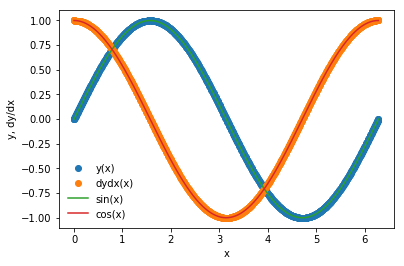

In [32]:
plt.plot(x,y[:,0],'o',label='y(x)')
plt.plot(x,y[:,1],'o',label='dydx(x)')
xx = np.linspace(0,2.0*np.pi,1000)
plt.plot(xx,np.sin(xx),label='sin(x)')
plt.plot(xx,np.cos(xx),label='cos(x)')
plt.xlabel('x')
plt.ylabel('y, dy/dx')
plt.legend(frameon=False)

# Plot the error
errors will exceed our tolerance

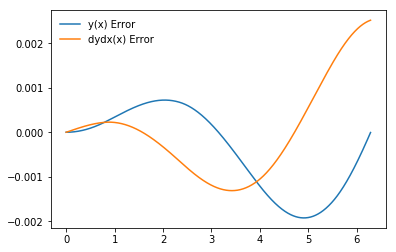

In [34]:
sin = np.sin(x)
cosin = np.cos(x)

y_error = (y[:,0]-sin)
dydx_error = (y[:,1]-cosin)

plt.plot(x,y_error,label="y(x) Error")
plt.plot(x,dydx_error, label="dydx(x) Error")
plt.legend(frameon=False)